In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_bert/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:3")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t <= 2015}
valid_range = {t: True for t in graph.times if t != None and (t > 2015) & (t < 2018)}
test_range  = {t: True for t in graph.times if t != None and t >= 2018}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), batch_size, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], batch_size)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'field': fids}, sampled_depth = 4, sampled_number = 128)

    el = []
    for i in edge_list['paper']['field']['rev_PF_in']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['field']['rev_PF_in'] = el

    el = []
    for i in edge_list['field']['paper']['PF_in']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['field']['paper']['PF_in'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list)
    '''
        Trace the paper_id and field_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    field_ids = np.arange(len(fids)) + node_dict['field'][0]
    ylabel = torch.zeros(batch_size, len(ids))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][list(ids).index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
from torch_geometric.nn import GATConv

class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, n_layers, dropout = 0.5):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.adapt = nn.Linear(in_dim, n_hid)
        self.drop  = nn.Dropout(dropout)
        self.in_dim = in_dim
        self.n_hid = n_hid
        for l in range(n_layers):
            self.gcs.append(GATConv(n_hid, n_hid // 4, heads=4))
    def forward(self, node_feature, edge_index):
        meta_xs = self.drop(F.relu(self.adapt(node_feature)))
        for gc in self.gcs:
            meta_xs = self.drop(F.relu(gc(meta_xs, edge_index)))
        return meta_xs
    def __repr__(self):
        return '{}(n_hid={}, n_layers={})'.format(
            self.__class__.__name__, self.n_hid, len(self.gcs))

In [6]:
'''
Paper-Field
'''
field_dict = dill.load(open(data_dir + 'field_dict.pk', 'rb'))
ids = np.array([graph.node_forward['field'][k] for k in field_dict if field_dict[k][0] == 'L1'])

paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in ids:
    for p_id in graph.edge_list['field']['paper']['PF_in'][f_id]:
        _time = graph.edge_list['field']['paper']['PF_in'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [7]:
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]), n_hid = 400, n_layers = 4).to(device)
classifier = Classifier(400, len(ids)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2000, eta_min=1e-6)

In [8]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 3000
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    
    model.train()
    train_losses = []
    for batch in np.arange(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), edge_index.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), edge_index.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/gat.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), edge_index.to(device))[paper_ids]
            res = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print("Test NDCG: " + str(test_ndcg))
    del train_data, valid_data

Data Preparation: 145.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (19.7s)  LR: 0.00060 Train Loss: 3.69  Valid Loss: 2.87  Valid NDCG: 0.4090
Data Preparation: 130.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (19.2s)  LR: 0.00069 Train Loss: 3.09  Valid Loss: 2.64  Valid NDCG: 0.5220
Data Preparation: 127.9s
Epoch: 3 (19.4s)  LR: 0.00078 Train Loss: 2.99  Valid Loss: 2.81  Valid NDCG: 0.4839
Data Preparation: 125.3s
Epoch: 4 (18.9s)  LR: 0.00085 Train Loss: 2.95  Valid Loss: 2.60  Valid NDCG: 0.5195
Data Preparation: 127.8s
Epoch: 5 (18.5s)  LR: 0.00091 Train Loss: 2.89  Valid Loss: 2.68  Valid NDCG: 0.4934
Test NDCG: 0.473149168644164
Data Preparation: 127.3s
Epoch: 6 (19.5s)  LR: 0.00096 Train Loss: 2.90  Valid Loss: 2.85  Valid NDCG: 0.4940
Data Preparation: 126.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 7 (19.1s)  LR: 0.00099 Train Loss: 2.89  Valid Loss: 2.69  Valid NDCG: 0.5399
Data Preparation: 126.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 8 (19.5s)  LR: 0.00100 Train Loss: 2.84  Valid Loss: 2.53  Valid NDCG: 0.5890
Data Preparation: 127.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 9 (19.7s)  LR: 0.00099 Train Loss: 2.83  Valid Loss: 2.30  Valid NDCG: 0.6494
Data Preparation: 129.4s
Epoch: 10 (19.1s)  LR: 0.00096 Train Loss: 2.80  Valid Loss: 2.48  Valid NDCG: 0.6039
Test NDCG: 0.5963929572987076
Data Preparation: 126.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 (18.4s)  LR: 0.00092 Train Loss: 2.56  Valid Loss: 2.12  Valid NDCG: 0.6539
Data Preparation: 128.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 12 (19.7s)  LR: 0.00086 Train Loss: 2.44  Valid Loss: 2.20  Valid NDCG: 0.6559
Data Preparation: 126.4s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 13 (18.6s)  LR: 0.00079 Train Loss: 2.31  Valid Loss: 1.97  Valid NDCG: 0.6896
Data Preparation: 131.1s
Epoch: 14 (19.3s)  LR: 0.00070 Train Loss: 2.21  Valid Loss: 2.04  Valid NDCG: 0.6622
Data Preparation: 131.5s
Epoch: 15 (19.4s)  LR: 0.00061 Train Loss: 2.14  Valid Loss: 2.04  Valid NDCG: 0.6838
Test NDCG: 0.5934243774415573
Data Preparation: 132.3s
Epoch: 16 (19.1s)  LR: 0.00051 Train Loss: 2.08  Valid Loss: 2.13  Valid NDCG: 0.6671
Data Preparation: 125.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 17 (19.6s)  LR: 0.00042 Train Loss: 2.02  Valid Loss: 1.77  Valid NDCG: 0.7245
Data Preparation: 128.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 18 (18.9s)  LR: 0.00032 Train Loss: 1.86  Valid Loss: 1.83  Valid NDCG: 0.7259
Data Preparation: 125.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 19 (19.7s)  LR: 0.00024 Train Loss: 1.81  Valid Loss: 1.61  Valid NDCG: 0.7687
Data Preparation: 130.8s
Epoch: 20 (19.2s)  LR: 0.00016 Train Loss: 1.76  Valid Loss: 1.80  Valid NDCG: 0.7310
Test NDCG: 0.6963492185646014
Data Preparation: 129.4s
Epoch: 21 (18.2s)  LR: 0.00009 Train Loss: 1.71  Valid Loss: 1.87  Valid NDCG: 0.7016
Data Preparation: 123.8s
Epoch: 22 (19.1s)  LR: 0.00005 Train Loss: 1.67  Valid Loss: 1.77  Valid NDCG: 0.7337
Data Preparation: 126.3s
Epoch: 23 (19.5s)  LR: 0.00001 Train Loss: 1.70  Valid Loss: 1.74  Valid NDCG: 0.7345
Data Preparation: 126.4s
Epoch: 24 (18.2s)  LR: 0.00000 Train Loss: 1.67  Valid Loss: 1.82  Valid NDCG: 0.7315
Data Preparation: 130.2s
Epoch: 25 (19.1s)  LR: 0.00001 Train Loss: 1.67  Valid Loss: 1.73  Valid NDCG: 0.7324
Test NDCG: 0.7225532285320537
Data Preparation: 127.4s
Epoch: 26 (18.9s)  LR: 0.00003 Train Loss: 1.63  Valid Loss: 1.74  Valid NDCG: 0.7472
Data Preparation: 131.7s
Epoch: 27 (18.8s)  LR: 0.00007 Train Loss: 1.62  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 37 (19.0s)  LR: 0.00090 Train Loss: 1.59  Valid Loss: 1.55  Valid NDCG: 0.7741
Data Preparation: 126.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 38 (19.3s)  LR: 0.00095 Train Loss: 1.54  Valid Loss: 1.61  Valid NDCG: 0.7799
Data Preparation: 128.9s
Epoch: 39 (19.8s)  LR: 0.00098 Train Loss: 1.51  Valid Loss: 1.62  Valid NDCG: 0.7674
Data Preparation: 128.0s
Epoch: 40 (19.6s)  LR: 0.00100 Train Loss: 1.53  Valid Loss: 1.71  Valid NDCG: 0.7514
Test NDCG: 0.7046854019846831
Data Preparation: 127.5s
Epoch: 41 (19.4s)  LR: 0.00100 Train Loss: 1.46  Valid Loss: 1.97  Valid NDCG: 0.6721
Data Preparation: 137.8s
Epoch: 42 (19.9s)  LR: 0.00097 Train Loss: 1.53  Valid Loss: 1.73  Valid NDCG: 0.7735
Data Preparation: 140.0s
Epoch: 43 (19.2s)  LR: 0.00093 Train Loss: 1.41  Valid Loss: 1.60  Valid NDCG: 0.7488
Data Preparation: 155.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 44 (20.6s)  LR: 0.00088 Train Loss: 1.35  Valid Loss: 1.51  Valid NDCG: 0.7999
Data Preparation: 147.3s
Epoch: 45 (21.0s)  LR: 0.00081 Train Loss: 1.37  Valid Loss: 1.65  Valid NDCG: 0.7886
Test NDCG: 0.6769632719229253
Data Preparation: 148.4s
Epoch: 46 (19.1s)  LR: 0.00072 Train Loss: 1.33  Valid Loss: 1.53  Valid NDCG: 0.7986
Data Preparation: 143.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 47 (20.6s)  LR: 0.00063 Train Loss: 1.33  Valid Loss: 1.42  Valid NDCG: 0.8105
Data Preparation: 140.4s
Epoch: 48 (20.6s)  LR: 0.00054 Train Loss: 1.32  Valid Loss: 1.51  Valid NDCG: 0.7884
Data Preparation: 144.6s
Epoch: 49 (21.0s)  LR: 0.00044 Train Loss: 1.79  Valid Loss: 1.53  Valid NDCG: 0.7781
Data Preparation: 150.3s
Epoch: 50 (20.7s)  LR: 0.00035 Train Loss: 1.36  Valid Loss: 1.52  Valid NDCG: 0.8053
Test NDCG: 0.7676916890550638
Data Preparation: 145.1s
Epoch: 51 (18.9s)  LR: 0.00026 Train Loss: 1.28  Valid Loss: 1.58  Valid NDCG: 0.7740
Data Preparation: 146.6s
Epoch: 52 (19.9s)  LR: 0.00018 Train Loss: 1.25  Valid Loss: 1.50  Valid NDCG: 0.7983
Data Preparation: 147.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 53 (18.9s)  LR: 0.00011 Train Loss: 1.25  Valid Loss: 1.41  Valid NDCG: 0.8180
Data Preparation: 148.5s
Epoch: 54 (20.3s)  LR: 0.00006 Train Loss: 1.23  Valid Loss: 1.67  Valid NDCG: 0.7594
Data Preparation: 147.0s
Epoch: 55 (20.6s)  LR: 0.00002 Train Loss: 1.21  Valid Loss: 1.49  Valid NDCG: 0.7947
Test NDCG: 0.7100988265196065
Data Preparation: 146.5s
Epoch: 56 (21.3s)  LR: 0.00000 Train Loss: 1.25  Valid Loss: 1.73  Valid NDCG: 0.7431
Data Preparation: 138.1s
Epoch: 57 (21.1s)  LR: 0.00000 Train Loss: 1.24  Valid Loss: 1.43  Valid NDCG: 0.8038
Data Preparation: 152.5s
Epoch: 58 (18.8s)  LR: 0.00002 Train Loss: 1.21  Valid Loss: 1.46  Valid NDCG: 0.8113
Data Preparation: 150.8s
Epoch: 59 (21.4s)  LR: 0.00006 Train Loss: 1.24  Valid Loss: 1.56  Valid NDCG: 0.7884
Data Preparation: 149.2s
Epoch: 60 (19.6s)  LR: 0.00012 Train Loss: 1.23  Valid Loss: 1.68  Valid NDCG: 0.7698
Test NDCG: 0.7408625393910572
Data Preparation: 141.4s
Epoch: 61 (20.3s)  LR: 0.00018 Train Loss: 1.22  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 79 (19.4s)  LR: 0.00066 Train Loss: 1.20  Valid Loss: 1.38  Valid NDCG: 0.8241
Data Preparation: 153.6s
Epoch: 80 (20.4s)  LR: 0.00056 Train Loss: 1.18  Valid Loss: 1.62  Valid NDCG: 0.7514
Test NDCG: 0.6446258649732912
Data Preparation: 151.0s
Epoch: 81 (22.1s)  LR: 0.00047 Train Loss: 1.25  Valid Loss: 1.72  Valid NDCG: 0.7131
Data Preparation: 147.5s
Epoch: 82 (19.2s)  LR: 0.00037 Train Loss: 1.20  Valid Loss: 1.38  Valid NDCG: 0.8213
Data Preparation: 149.4s
Epoch: 83 (20.3s)  LR: 0.00028 Train Loss: 1.12  Valid Loss: 1.45  Valid NDCG: 0.7818
Data Preparation: 152.3s
Epoch: 84 (20.7s)  LR: 0.00020 Train Loss: 1.14  Valid Loss: 1.56  Valid NDCG: 0.7560
Data Preparation: 150.8s
Epoch: 85 (20.2s)  LR: 0.00013 Train Loss: 1.12  Valid Loss: 1.75  Valid NDCG: 0.7166
Test NDCG: 0.7054293534519833
Data Preparation: 153.9s
Epoch: 86 (18.6s)  LR: 0.00007 Train Loss: 1.08  Valid Loss: 1.62  Valid NDCG: 0.7596
Data Preparation: 157.4s
Epoch: 87 (19.4s)  LR: 0.00003 Train Loss: 1.09  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 101 (19.3s)  LR: 0.00087 Train Loss: 1.20  Valid Loss: 1.30  Valid NDCG: 0.8392
Data Preparation: 157.2s
Epoch: 102 (19.1s)  LR: 0.00093 Train Loss: 1.23  Valid Loss: 1.56  Valid NDCG: 0.7822
Data Preparation: 154.1s
Epoch: 103 (18.2s)  LR: 0.00097 Train Loss: 1.32  Valid Loss: 1.54  Valid NDCG: 0.7944
Data Preparation: 156.0s
Epoch: 104 (18.2s)  LR: 0.00099 Train Loss: 1.24  Valid Loss: 1.61  Valid NDCG: 0.7586
Data Preparation: 149.5s
Epoch: 105 (18.9s)  LR: 0.00100 Train Loss: 1.21  Valid Loss: 1.59  Valid NDCG: 0.7705
Test NDCG: 0.6383168725601743
Data Preparation: 157.1s
Epoch: 106 (18.9s)  LR: 0.00099 Train Loss: 1.19  Valid Loss: 1.82  Valid NDCG: 0.7154
Data Preparation: 167.2s
Epoch: 107 (18.5s)  LR: 0.00096 Train Loss: 1.27  Valid Loss: 1.83  Valid NDCG: 0.7233
Data Preparation: 175.7s
Epoch: 108 (20.9s)  LR: 0.00091 Train Loss: 1.23  Valid Loss: 1.93  Valid NDCG: 0.7109
Data Preparation: 166.3s
Epoch: 109 (19.0s)  LR: 0.00084 Train Loss: 1.20  Valid Loss: 1.64  Valid 

Test NDCG: 0.7700378135475453
Data Preparation: 139.4s
Epoch: 171 (21.1s)  LR: 0.00097 Train Loss: 1.32  Valid Loss: 1.77  Valid NDCG: 0.7227
Data Preparation: 130.8s
Epoch: 172 (20.0s)  LR: 0.00094 Train Loss: 1.21  Valid Loss: 1.80  Valid NDCG: 0.7311
Data Preparation: 137.9s
Epoch: 173 (20.1s)  LR: 0.00088 Train Loss: 1.36  Valid Loss: 2.43  Valid NDCG: 0.5987
Data Preparation: 131.6s
Epoch: 174 (19.3s)  LR: 0.00081 Train Loss: 1.36  Valid Loss: 2.04  Valid NDCG: 0.7024
Data Preparation: 136.9s
Epoch: 175 (19.8s)  LR: 0.00073 Train Loss: 1.12  Valid Loss: 1.80  Valid NDCG: 0.7411
Test NDCG: 0.7203141298499607
Data Preparation: 130.3s
Epoch: 176 (19.7s)  LR: 0.00064 Train Loss: 1.15  Valid Loss: 1.68  Valid NDCG: 0.7506
Data Preparation: 128.9s
Epoch: 177 (18.7s)  LR: 0.00054 Train Loss: 1.07  Valid Loss: 2.03  Valid NDCG: 0.6924
Data Preparation: 127.9s
Epoch: 178 (19.1s)  LR: 0.00044 Train Loss: 1.09  Valid Loss: 1.71  Valid NDCG: 0.7637
Data Preparation: 125.3s
Epoch: 179 (18.8s) 

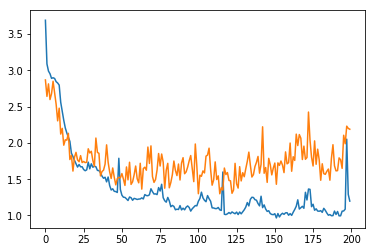

In [9]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [10]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(100):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5499076208170945 0.05888196896956725
0.4344073654740088 0.11355718708779072


In [11]:
model = torch.load('./save/gat.pt')

In [12]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(100):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.7588846660502406 0.05919264573443884
0.7511702776761893 0.11989918615309002
